<a href="https://colab.research.google.com/github/Abhinavk910/Natural-Language-Processing/blob/master/Sentiment%20Analysis/Sentiment_analysis_of_Movie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Data To Colab

In [0]:
from google.colab import files
files.upload()


! pip install -q kaggle
! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [0]:
! kaggle competitions download -c sentiment-analysis-on-movie-reviews

  0% 0.00/471k [00:00<?, ?B/s]
100% 471k/471k [00:00<00:00, 73.5MB/s]
  0% 0.00/583k [00:00<?, ?B/s]
100% 583k/583k [00:00<00:00, 38.3MB/s]
  0% 0.00/1.21M [00:00<?, ?B/s]
100% 1.21M/1.21M [00:00<00:00, 81.9MB/s]


In [0]:
! kaggle datasets download -d terenceliu4444/glove6b100dtxt

 92% 121M/131M [00:02<00:00, 62.3MB/s]
100% 131M/131M [00:02<00:00, 65.0MB/s]


In [0]:
! kaggle datasets download -d abhinavkum/excessive-stopword

  0% 0.00/2.55k [00:00<?, ?B/s]
100% 2.55k/2.55k [00:00<00:00, 5.46MB/s]


In [0]:
! unzip -q "train.tsv.zip"
! unzip -q 'test.tsv.zip'
! unzip -q 'excessive-stopword.zip'
! unzip -q 'glove6b100dtxt.zip'

# Importing Library

In [0]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import re

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TreebankWordTokenizer
nltk.download('wordnet')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold  

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Importing Data

 The Rotten Tomatoes dataset. [Data Description](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data) 

In [0]:
train_df = pd.read_csv('train.tsv', sep='\t')
print(train_df.shape)
train_df.head(3)

(156060, 4)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1
1,2,1,A series of escapades demonstrating the adage that what is good for the goose,2
2,3,1,A series,2


In [0]:
test_df = pd.read_csv('test.tsv', sep = '\t')
print(test_df.shape)
test_df.head(3)

(66292, 3)


,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine effort .
1,156062,8545,An intermittently pleasing but mostly routine effort
2,156063,8545,An


In [0]:
train_df['from_which'] = 'train'
test_df['from_which'] = 'test'
data = train_df.append(test_df,ignore_index= True, sort = False)
print(data.shape)
data.tail(3)

(222352, 5)


,PhraseId,SentenceId,Phrase,Sentiment,from_which
222349,222350,11855,"A long-winded ,",NaN,test
222350,222351,11855,A long-winded,NaN,test
222351,222352,11855,predictable scenario,NaN,test


#  Understanding Data And Data Exploration

In [0]:
data.describe()

,PhraseId,SentenceId,Sentiment
count,222352.000000,222352.000000,156060.000000
mean,111176.500000,5879.059550,2.063578
std,64187.637865,3506.664769,0.893832
min,1.000000,1.000000,0.000000
25%,55588.750000,2775.000000,2.000000
50%,111176.500000,5893.000000,2.000000
75%,166764.250000,8987.000000,3.000000
max,222352.000000,11855.000000,4.000000


In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222352 entries, 0 to 222351
Data columns (total 5 columns):
PhraseId      222352 non-null int64
SentenceId    222352 non-null int64
Phrase        222352 non-null object
Sentiment     156060 non-null float64
from          222352 non-null object
dtypes: float64(1), int64(2), object(2)
memory usage: 8.5+ MB


Sentiment has only 156060 null value cus only train_df data has value in Sentiment.

Text(0.5, 1.0, 'Percentage Distribution of Sentiment')

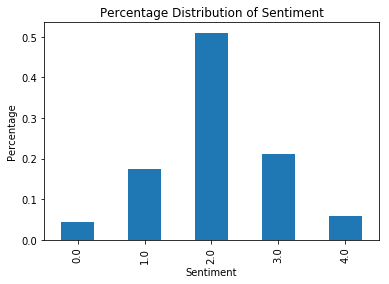

In [0]:
data['Sentiment'].value_counts(normalize = True).sort_index().plot(kind = 'bar')
plt.xlabel('Sentiment')
plt.ylabel('Percentage')
plt.title('Percentage Distribution of Sentiment')

In [0]:
print('Total Number of Phrase :-', len(data.PhraseId.unique())) # Same as max value in data.describe()

Total Number of Phrase :- 222352


In [0]:
print('Total Number of Sentences :-', len(data.SentenceId.unique()))   

Total Number of Sentences :- 11839


This 11839 unique sentenceId but in data.describe max value is 11855.

In [0]:
data.tail(1)

,PhraseId,SentenceId,Phrase,Sentiment,from_which
222351,222352,11855,predictable scenario,NaN,test


In [0]:
# These Sentence Id is not in dataset
[i for i in np.arange(1,11855) if i not in data.SentenceId.unique()] 

[2628,
 2746,
 4044,
 4365,
 4761,
 5695,
 5916,
 6231,
 6358,
 6673,
 6922,
 7325,
 7473,
 8443,
 8530,
 9147]

Text(0.5, 1.0, 'Frequency Distribution of No. of Phrases')

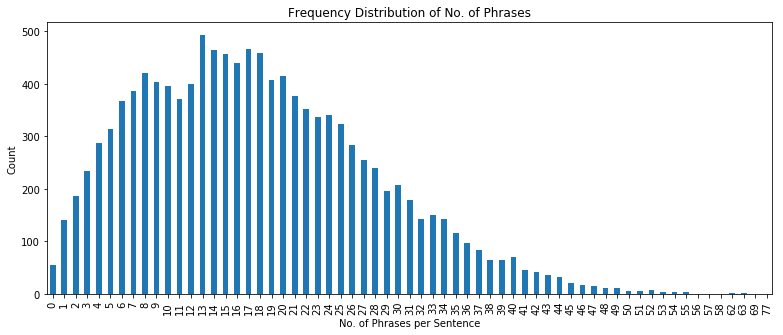

In [0]:
# Frequency distribution of No. of Phrases per sentences.
(data.SentenceId.value_counts()-1).value_counts().sort_index().plot(kind = 'bar', figsize = (13,5))
plt.xlabel('No. of Phrases per Sentence')
plt.ylabel('Count')
plt.title('Frequency Distribution of No. of Phrases')

### GLove  Vector Import

In [0]:
glove2vec = {}

with open('glove.6B.100d.txt') as f:
    for line in f:
        values = line.split(" ")
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        glove2vec[word] = vec
print('Found %s word vectors.' % len(glove2vec))

Found 400000 word vectors.


## Text

In [0]:
data.head()

,PhraseId,SentenceId,Phrase,Sentiment,from_which,length,NWC,PWC,SNWC,SPWC,NeWC,NoLWNeC,NoLWSNC,capitals,caps_per_length,num_exclamation_marks,num_question_marks,num_punctuation
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1.0,train,35,0,0,0,2,23,2,0,1,0.028571,0,0,2
1,2,1,A series of escapades demonstrating the adage that what is good for the goose,2.0,train,14,0,0,0,1,12,0,0,1,0.071429,0,0,0
2,3,1,A series,2.0,train,2,0,0,0,0,2,0,0,1,0.500000,0,0,0
3,4,1,A,2.0,train,1,0,0,0,0,1,0,0,1,1.000000,0,0,0
4,5,1,series,2.0,train,1,0,0,0,0,1,0,0,0,0.000000,0,0,0


In [0]:
# Count only words.
data['length'] = data.Phrase.apply(lambda x: len(re.findall(r'[\w\'\"]+', x)))

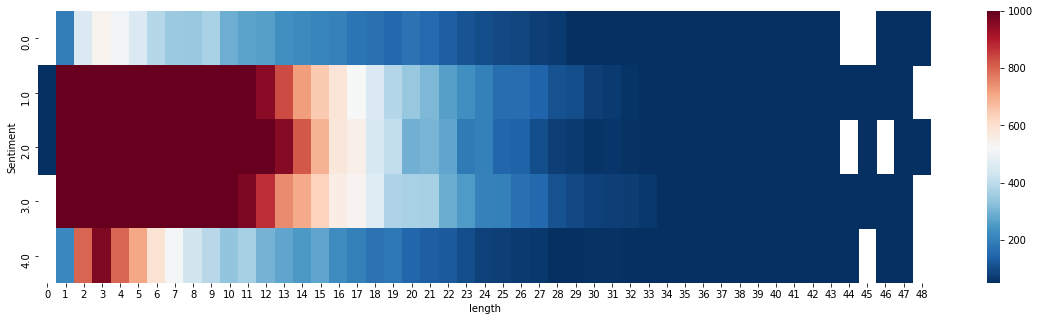

In [0]:
len_sen = data.groupby(['Sentiment', 'length']).agg('size').reset_index()
len_sen = pd.pivot(len_sen, 'Sentiment', 'length', 0)
plt.figure(figsize = (20,5))
sns.heatmap(len_sen, cmap = "RdBu_r", vmax= 1000, vmin= 50)

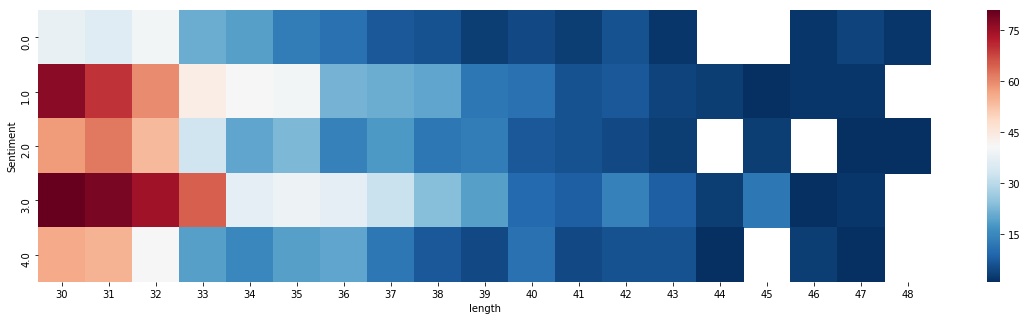

In [0]:
plt.figure(figsize = (20,5))
sns.heatmap(len_sen.iloc[:,30:],  cmap = "RdBu_r")

In [0]:
No_length_words_neutral = data.query('length == 0 and Sentiment == 2').Phrase.tolist()
print('Length_of_No_length_neutral_words', len(No_length_words_neutral))

Length_of_No_length_neutral_words 26


In [0]:
No_length_words_neutral

[',',
 '.',
 '--',
 '``',
 "''",
 "'",
 '...',
 '`',
 '-',
 '!',
 ':',
 '?',
 ';',
 '=',
 '$',
 '?!?',
 '&',
 '\\*\\*',
 '\\/',
 '\\*',
 '#',
 '\\*\\*\\*',
 '\\*\\*\\*\\*',
 "!? '",
 '!?',
 '+']

In [0]:
No_length_words_somewhatnegative = data.query('length == 0 and Sentiment == 1').Phrase.tolist()
print('Length_of_No_length_somewhatnegative_words', len(No_length_words_somewhatnegative))

Length_of_No_length_somewhatnegative_words 1


In [0]:
No_length_words_somewhatnegative

[' ']

In [0]:
Positive_words = data.query('length == 1 and Sentiment == 4').Phrase.tolist()
print('Length_of_Positive_words', len(Positive_words))

Length_of_Positive_words 219


In [0]:
Negative_words = data.query('length == 1 and Sentiment == 0').Phrase.tolist()
print('Length_of_Negative_words', len(Negative_words))

Length_of_Negative_words 198


In [0]:
Somewhat_negative_words = data.query('length == 1 and Sentiment == 1').Phrase.tolist()
print('Length_of_Somewhat_Negative_words', len(Somewhat_negative_words))

Length_of_Somewhat_Negative_words 1820


In [0]:
Neutral = data.query('length == 1 and Sentiment == 2').Phrase.tolist()
print('Length_of_Neutral_word', len(Neutral))

Length_of_Neutral_word 12173


In [0]:
Somewhat_positive_words = data.query('length == 1 and Sentiment == 3').Phrase.tolist()
print('Length_of_Somewhat_Positive_words', len(Somewhat_positive_words))

Length_of_Somewhat_Positive_words 1884


In [0]:
data['NWC'] = data.Phrase.apply(lambda x: len(set(i for i in x.split(" ") if i in Negative_words)))
data['PWC'] = data.Phrase.apply(lambda x: len(set(i for i in x.split(" ") if i in Positive_words)))
data['SNWC'] = data.Phrase.apply(lambda x: len(set(i for i in x.split(" ") if i in Somewhat_negative_words)))
data['SPWC'] = data.Phrase.apply(lambda x: len(set(i for i in x.split(" ") if i in Somewhat_positive_words)))
data['NeWC'] = data.Phrase.apply(lambda x: len(set(i for i in x.split(" ") if i in Neutral)))
data['NoLWNeC'] = data.Phrase.apply(lambda x: len(set(i for i in x.split(" ") if i in No_length_words_neutral)))
data['NoLWSNC'] = data.Phrase.apply(lambda x: len(set(i for i in x.split(" ") if i in No_length_words_somewhatnegative)))

In [0]:
data['capitals'] = data.Phrase.apply(lambda x: len(re.findall(r'[A-Z]', x)))
data['caps_per_length'] = data['capitals'] / data['length']
data['num_exclamation_marks'] = data.Phrase.apply(lambda X: len(re.findall(r'!', X)))
data['num_question_marks'] = data.Phrase.apply(lambda X: len(re.findall(r'\?', X)))
data['num_punctuation'] = data.Phrase.apply(lambda X: len(re.findall(r'[,.:;]', X)))

### Tokenize Problem

In [0]:
# 's Problem
for row in data.itertuples(index = False):
  B = re.findall(r'\w+\'s',row[2])
  if len(B) != 0:
    print(B)

There is no word with 's at there 

In [0]:
abbre1 = []
for row in data.itertuples(index = False):
  B = re.findall(r'\w+es',row[2])
  for i in B:
    if i not in abbre1:
      abbre1.append(i)

In [0]:
abbre1
abbre1 = [i.lower() for i in abbre1]
B = [i for i in abbre1 if i in glove2vec.keys()]
print('No. of words %s \n which are in glove vec %s' % (len(abbre1), len(B)))

No. of words 1732 
 which are in glove vec 1216


In [0]:
# Now word having contraction form
abbre2 = []
for row in data.itertuples(index = False):
  B = re.findall(r'\w+[\'\"]\w+',row[2])
  for i in B:
    if i not in abbre2:
      abbre2.append(i)

In [0]:
abbre2l = [i.lower() for i in abbre2]
B = [i for i in abbre2l if i in glove2vec.keys()]
print('No. of words %s \n which are in glove vec %s' % (len(abbre2l), len(B)))

No. of words 8 
 which are in glove vec 8


In [0]:
for i in abbre2:
  for row in data.itertuples(index = False):
    if i in row[2]:
      print(row[2])
      break

But it does n't leave you with much .
The screenplay by James Eric , James Horton and director Peter O'Fallon ... is so pat it makes your teeth hurt .
C'mon !
Despite engaging offbeat touches , Knockaround Guys rarely seems interested in kicking around a raison d'etre that 's as fresh-faced as its young-guns cast .
Recalls quiet freak-outs like L'Avventura and Repulsion .
Denis O'Neill 's script avoids the prime sports cliche , a last-second goal to win the championship , but it neglects few others .
Some movies are like a tasty hors-d'oeuvre ; this one is a feast .
Audiences can be expected to suspend their disbelief only so far -- and that does not include the 5 o'clock shadow on the tall wooden kid as he skips off to school .


In [0]:
abbre3 = []
for row in data.itertuples(index = False):
  B = re.findall(r'\w+-\w+',row[2])
  for i in B:
    if i not in abbre3:
      abbre3.append(i)

In [0]:
abbre3
abbre3 = [i.lower() for i in abbre3]
B = [i for i in abbre3 if i in glove2vec.keys()]
print('No. of words %s \n which are in glove vec %s' % (len(abbre3), len(B)))

No. of words 2151 
 which are in glove vec 811


In [0]:
abbre4 = []
for row in data.itertuples(index = False):
  B = re.findall(r'\w+\.[\w]?',row[2])
  for i in B:
    if i not in abbre4:
      abbre4.append(i)

In [0]:
print(len(abbre4), '\n Printing five from list')
abbre4[:5]

73 
 Printing five from list


['Mr.', 'U.N', 'D.', 'S.C', 'E.T']

In [0]:
abbre4
abbre4 = [i.lower() for i in abbre4]
B = [i for i in abbre4 if i in glove2vec.keys()]
print('No. of words %s \n which are in glove vec %s' % (len(abbre4), len(B)))

No. of words 73 
 which are in glove vec 58


In [0]:
# data.query('from_which == "test" and length == 1')

In [0]:
stopwords =set(w.lower().strip() for w in open("stopwords.txt"))
stopwords.add(".")
stopwords.add(",")
len(stopwords)

722

# Feature Extraction

In [0]:
def stopwordcount(x):
    tokens = x.lower().split(" ")
    stopword = [token for token in tokens if token in stopwords]
    return len(stopword)/len(tokens)
  
tokenizer_treebank = TreebankWordTokenizer()
lemma = WordNetLemmatizer()
def forming(x):
    x = x.lower()
    tokens = tokenizer_treebank.tokenize(x)
    tokens = [token for token in tokens if token not in stopwords]
    tokens = [lemma.lemmatize(token) for token in tokens]
    sent = (" ").join(tokens)
    return sent

In [0]:
data['tokenize'] = data.Phrase.apply(lambda x:forming(x))
data['length_included'] = data.Phrase.apply(lambda x: len(x.split(" ")))
data['sw_per_phrase'] = data.Phrase.apply(lambda x: stopwordcount(x))
data['length_after'] = data.apply(lambda x: len(x.tokenize.split(" ")) if x.sw_per_phrase != 1 else 0, axis = 1)
data.head(2)

,PhraseId,SentenceId,Phrase,Sentiment,from_which,length,NWC,PWC,SNWC,SPWC,NeWC,NoLWNeC,NoLWSNC,capitals,caps_per_length,num_exclamation_marks,num_question_marks,num_punctuation,tokenize,length_included,sw_per_phrase,length_after
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1.0,train,35,0,0,0,2,23,2,0,1,0.028571,0,0,2,series escapade demonstrating adage goose gander occasionally amuses amount story,37,0.729730,10
1,2,1,A series of escapades demonstrating the adage that what is good for the goose,2.0,train,14,0,0,0,1,12,0,0,1,0.071429,0,0,0,series escapade demonstrating adage goose,14,0.642857,5


In [0]:
train_df = data.query('from_which == "train"')
train_df.drop(['from_which'], inplace = True, axis = 1)
print(train_df.shape)

test_df = data.query('from_which == "test"')
test_df.drop(['from_which'], inplace = True, axis = 1)
print(test_df.shape)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(156060, 21)
(66292, 21)


In [0]:
train_df.head(1)

,PhraseId,SentenceId,Phrase,Sentiment,length,NWC,PWC,SNWC,SPWC,NeWC,NoLWNeC,NoLWSNC,capitals,caps_per_length,num_exclamation_marks,num_question_marks,num_punctuation,tokenize,length_included,sw_per_phrase,length_after
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1.0,35,0,0,0,2,23,2,0,1,0.028571,0,0,2,series escapade demonstrating adage goose gander occasionally amuses amount story,37,0.72973,10


In [0]:
train_df.columns

Index(['PhraseId', 'SentenceId', 'Phrase', 'Sentiment', 'length', 'NWC', 'PWC',
       'SNWC', 'SPWC', 'NeWC', 'NoLWNeC', 'NoLWSNC', 'capitals',
       'caps_per_length', 'num_exclamation_marks', 'num_question_marks',
       'num_punctuation', 'tokenize', 'length_included', 'sw_per_phrase',
       'length_after'],
      dtype='object')

# Glove with Logistic Regression

**Glove with Logistic Regression**

In [0]:
def change(content):
  X = np.zeros([len(content), 100])
  emptycount = 0
  n = 0
  for sentence in content:
      vecs = []
      tokens = sentence.lower().split()
      for token in tokens:
          if token in glove2vec:
              vec = glove2vec[token]
              vecs.append(vec)
      if len(vecs) > 0:
          vecs = np.array(vecs)
          X[n] = np.mean(vecs, axis = 0)
      else:
          emptycount += 1
      n += 1

  print('No. of samples whoese word not fount is %s / %s' % (emptycount, len(content)))
  return X

In [0]:
X = change(train_df.tokenize)
X.shape

No. of samples whoese word not fount is 7222 / 156060


(156060, 100)

In [0]:
extra = np.array(train_df.iloc[:,[4,5,6,7,8,9,10,11,12,14,15,16,18,19,20]].values)
extra.shape

(156060, 15)

array([7. , 0. , 1. , 0. , 0. , 4. , 1. , 0. , 1. , 0. , 0. , 1. , 8. ,
       0.5, 4. ])

In [0]:
X_train = np.concatenate([X, extra], axis = 1)
X_train.shape

(156060, 115)

In [0]:
y = train_df.iloc[:,3]
y.shape

(156060,)

In [0]:
X_test = change(test_df.tokenize)
X_test.shape

No. of samples whoese word not fount is 3649 / 66292


(66292, 100)

In [0]:
extra = np.array(test_df.iloc[:,[4,5,6,7,8,9,10,11,12,14,15,16,18,19,20]].values)
extra.shape

(66292, 15)

In [0]:
X_test = np.concatenate([X_test, extra], axis = 1)
X_test.shape

(66292, 115)

In [0]:
def check(model):
    skf = StratifiedKFold(n_splits=5, shuffle = True , random_state=42)
    return cross_val_score(model, X_train, y, scoring = 'accuracy', cv = skf).mean()

In [0]:
modellor = LogisticRegression()
print('Accuracy Score for LogisticRegression :-',check(modellor))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

Accuracy Score for LogisticRegression :- 0.5827182039589085


In [0]:
sub = pd.read_csv('sampleSubmission.csv')
sub.Sentiment = modellor.fit(X_train, y).predict(X_test)
sub.to_csv('finallornewton_cg.csv', index=False)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
